# E3 Balanced Sample
So the last sample was not balanced between patients and controls which makes it difficult to interpret ratios between them in the subtypes and also might skew our results. So for the new sample, I'll pick off where I left the previous sample. 
 
This means: 
 
- Only 4 sites with the largest number of subjects (USM, PITT, NYU, UCLA_1, UCLA_2)
- Include all patients with ADOS severity scores 
- Match controls based on age

In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Set the paths
full_pheno = '/data1/abide/Pheno/full_merged_pheno.csv'
out_path = '/data1/abide/Pheno/'

In [45]:
pheno = pd.read_csv(full_pheno)
# Set the 4 sites to be included
include = ['USM', 'PITT', 'NYU', 'UCLA_1', 'UCLA_2']
pheno = pheno[pheno['SITE_ID'].isin(include)]
pheno.loc[pheno.SITE_ID == 'UCLA_1', 'SITE_ID'] = 'UCLA'
pheno.loc[pheno.SITE_ID == 'UCLA_2', 'SITE_ID'] = 'UCLA'

In [46]:
# Create new variable from ratio of VIQ/PIQ
pheno['VPR'] = pheno['VIQ'].values / pheno['PIQ'].values
# get the mask of ados subjects with diagnosis
mask_ados = ~np.isnan(pheno['ADOS_SOCOM_SEV'].values) * pheno['DX_GROUP'].values == 1
# get the mask of ados subjects without diagnosis
mask_ados_control = ~np.isnan(pheno['ADOS_SOCOM_SEV'].values) * pheno['DX_GROUP'].values == 2
# get the mask of control subjects
mask_control = pheno['DX_GROUP'].values == 2 * np.isnan(pheno['ADOS_SOCOM_SEV'].values)
# get the indices of the subjects in the full sample
ados_index = np.where(mask_ados)[0]
control_ados_index = np.where(mask_ados_control)[0]
control_index = np.where(mask_control)[0]
# create the pheno slices
ados = pheno[mask_ados]
control = pheno[mask_control]

## Show the samples as they are
Right now we have constrained them to the 4 biggest sites but we haven't matched anything yet.

In [47]:
def plot_sample(ados, ctrl):
    ados_grouped = ados.groupby('SITE_ID')
    ctrl_grouped = ctrl.groupby('SITE_ID')
    site_names = ados_grouped.groups.keys()

    ados_ages = [ados_grouped.get_group(st)['AGE_AT_SCAN'].values for st in site_names]
    ados_dx = [ados_grouped.get_group(st)['DX_GROUP'].values for st in site_names]

    ctrl_ages = [ctrl_grouped.get_group(st)['AGE_AT_SCAN'].values for st in site_names]
    ctrl_dx = [ctrl_grouped.get_group(st)['DX_GROUP'].values for st in site_names]


    f = plt.figure(figsize=(10,4))
    ax = f.add_subplot(111)
    y_ados = np.array([])
    x_ados = np.array([])
    y_ctrl = np.array([])
    x_ctrl = np.array([])

    for idx, ados_ag in enumerate(ados_ages):
        # ados first
        l_ages = len(ados_ag)
        ind = np.ones((l_ages,))*idx+1
        jitter = (np.random.random(l_ages,)*2-1)*0.2
        ind += jitter

        x_ados = np.append(x_ados, ind)
        y_ados = np.append(y_ados, ados_ag)

        # now ctrl
        ctrl_ag = ctrl_ages[idx]
        l_ages = len(ctrl_ag)
        ind = np.ones((l_ages,))*idx+1
        jitter = (np.random.random(l_ages,)*2-1)*0.2
        ind += jitter

        x_ctrl = np.append(x_ctrl, ind)
        y_ctrl = np.append(y_ctrl, ctrl_ag)

    ad = ax.scatter(x_ados, y_ados, c='r', alpha=0.5)
    ct = ax.scatter(x_ctrl, y_ctrl, c='y', alpha=0.5)
    ax.legend((ad, ct),
               ('Patient', 'Control'),
               scatterpoints=1,
               loc='upper right',
               ncol=1,
               fontsize=10)
    tmp = ax.set_xticks(np.arange(len(site_names))+1)
    tmp = ax.set_xticklabels(site_names, rotation=70)
    tmp = ax.set_ylabel('Age')
    tmp = ax.set_title('Simple Matching ADOS sample')

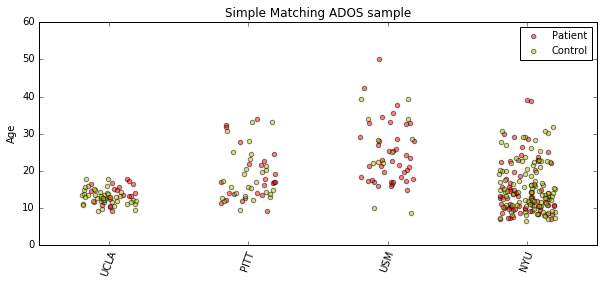

In [48]:
plot_sample(ados, control)

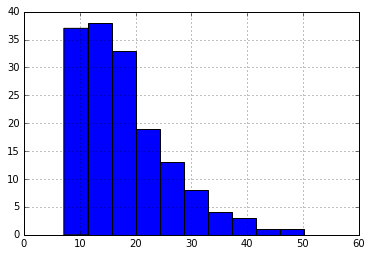

In [49]:
ados['AGE_AT_SCAN'].hist()

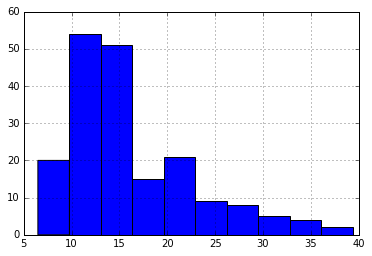

In [50]:
control['AGE_AT_SCAN'].hist()

Well, not perfect but also not a really bad sample. Let's start matching

In [51]:
def find_closest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [52]:
# Find a match and then replace the matched subject
ados_ids = list()
control_ids = list()
ados_index = np.where(mask_ados)[0]
control_index = np.where(mask_control)[0]
ages = pheno['AGE_AT_SCAN'].values

for ados_idx in ados_index:
    target_age = ages[ados_idx]
    # Match the controls
    control_ages = ages[control_index]
    best_id = find_closest(control_ages, target_age)
    match_idx = control_index[best_id]
    match_age = control_ages[best_id]
    dist_age = target_age - match_age

    if dist_age < 1:
        control_ids.append(match_idx)
        control_index = np.delete(control_index, best_id)
        ados_ids.append(ados_idx)

In [53]:
# Combine the two samples
ctrl_idx = np.array(control_ids)
ados_idx = np.array(ados_ids)
# Make a combined pheno of both of them
comb_ind = np.append(ctrl_idx, ados_idx)
combined = pheno.iloc[comb_ind]
# And make separate phenos for each of them
ados = pheno.iloc[ados_idx]
ctrl = pheno.iloc[ctrl_idx]

Look at the new sample

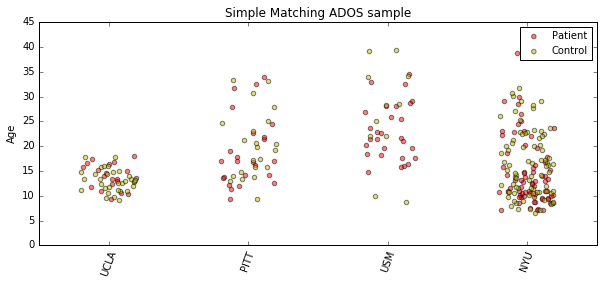

In [54]:
plot_sample(ados, ctrl)

While this certainly looks better, now we have some site bias because we are matching across the sites. Let's match within a site

In [55]:
ctrl_idx = np.array(control_ids)
ados_idx = np.array(ados_ids)
# Make a combined pheno of both of them
comb_ind = np.append(ctrl_idx, ados_idx)
combined = pheno.iloc[comb_ind]

In [56]:
len(ados)

144

In [57]:
len(ctrl)

144

In [58]:
combined.to_csv(os.path.join(out_path, 'site_cross_balanced_288.csv'), index=False)

In [35]:
# Find a match and then replace the matched subject
ados_ids = list()
control_ids = list()
ados_index = np.where(mask_ados)[0]
control_index = np.where(mask_control)[0]
ages = pheno['AGE_AT_SCAN'].values
sites = pheno['SITE_ID'].values

for ados_idx in ados_index:
    target_age = ages[ados_idx]
    target_site = sites[ados_idx]
    # Match controls from the same site
    controls = control_index[sites[control_index]==target_site]
    
    control_ages = ages[controls]
    best_id = find_closest(control_ages, target_age)
    match_idx = controls[best_id]
    match_age = control_ages[best_id]
    dist_age = target_age - match_age

    if dist_age < 1:
        control_ids.append(match_idx)
        control_index = np.delete(control_index, np.where(control_index==match_idx))
        ados_ids.append(ados_idx)

In [37]:
len(ados_ids)

118

In [38]:
len(control_ids)

118

In [39]:
# Combine the two samples
ctrl_idx = np.array(control_ids)
ados_idx = np.array(ados_ids)
# Make a combined pheno of both of them
comb_ind = np.append(ctrl_idx, ados_idx)
combined = pheno.iloc[comb_ind]
# And make separate phenos for each of them
ados = pheno.iloc[ados_idx]
ctrl = pheno.iloc[ctrl_idx]

In [40]:
ctrl['SITE_ID'].unique()

array(['NYU', 'PITT', 'UCLA', 'USM'], dtype=object)

In [41]:
ctrl['SITE_ID'].unique()

array(['NYU', 'PITT', 'UCLA', 'USM'], dtype=object)

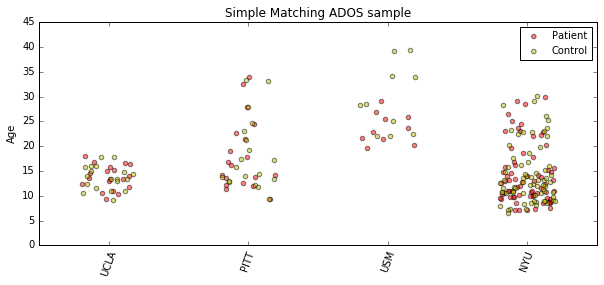

In [42]:
plot_sample(ados, ctrl)

In [43]:
ctrl_idx = np.array(control_ids)
ados_idx = np.array(ados_ids)
# Make a combined pheno of both of them
comb_ind = np.append(ctrl_idx, ados_idx)
combined = pheno.iloc[comb_ind]

In [44]:
combined.to_csv(os.path.join(out_path, 'site_full_balanced_236.csv'), index=False)

Alright, this looks like a better sample, although now we are missing about 40 subjects. We could also not care about the site effects and use that sample. Not sure.